In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from astropy.io import fits
import numpy  as np
import pandas as pd
import h5py

from tqdm import tqdm
from astropy import units
from astropy import units as u
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
from scipy.signal      import argrelextrema

import ehtplot
from matplotlib import pyplot as plt, cm

plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif",
#    "font.serif": ["Palatino"],
#    'mathtext.fontset': 'custom',
#    'mathtext.rm': 'Bitstream Vera Sans',
#    'mathtext.it': 'Bitstream Vera Sans:italic',
#    'mathtext.bf': 'Bitstream Vera Sans:bold',   
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
})

from common import dalt
from common import hallmark as hm
from common import viz
from common import io_ipole as io
from common import mockservation as ms

In [2]:
img_frame = io.load_mov([ 'model/Illinois_thermal/230GHz/Ma+0.5_w5/img_s05511_Rh160_i30.h5'],                         mean=True)
img_avg   = io.load_mov([f'model/Illinois_thermal/230GHz/Ma+0.5_w5/img_s05{i:03d}_Rh160_i30.h5'
                         for i in range(1000) # range(511,918)
                        ], mean=True)

In [3]:
with fits.open('data/reconst/mad_avg.fits') as hdul:
    img_mock = dalt.Image(hdul[0].data.T, 4.14e6 * u.Msun, 2.5077305106e+22 * u.cm, 86e9 * u.H, 0, 79.52842452054078 * 150 / 400, 79.52842452054078 * 150 / 400)   
#fig, ax = plt.subplots(1,1)
#viz.show(img_mock, ax=ax, cmap='afmhot_10us')

In [4]:
with fits.open('data/reconst/hops_avg.fits') as hdul:
    img_obs = dalt.Image(hdul[0].data.T, 4.14e6 * u.Msun, 2.5077305106e+22 * u.cm, 86e9 * u.H, 0, 79.52842452054078 * 150 / 400, 79.52842452054078 * 150 / 400)   
#fig, ax = plt.subplots(1,1)
#viz.show(img_obs, ax=ax, cmap='afmhot_10us')

In [5]:
print(np.max(img_frame), np.max(img_avg), np.max(img_mock), np.max(img_obs))

0.0008671743368556336 erg / (cm2 Hz s sr) 0.0006255806545950516 erg / (cm2 Hz s sr) 0.00027233541191485136 erg / (cm2 Hz s sr) 0.0002852638402558748 erg / (cm2 Hz s sr)


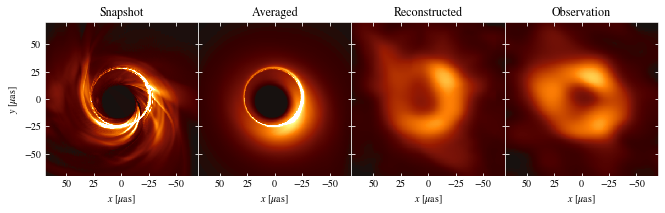

In [13]:
fig, axes = plt.subplots(1,4, figsize=(11,4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

viz.show(img_frame, ax=axes[0], cmap='afmhot_10us', vmin=0, vmax=0.00033, interpolation='none')
viz.show(img_avg,   ax=axes[1], cmap='afmhot_10us', vmin=0, vmax=0.00033, interpolation='none')
viz.show(img_mock,  ax=axes[2], cmap='afmhot_10us', vmin=0, vmax=0.00033, interpolation='none')
viz.show(img_obs,   ax=axes[3], cmap='afmhot_10us', vmin=0, vmax=0.00033, interpolation='none')

for ax in axes:
    ax.set_xlim( 70,-70)
    ax.set_ylim(-70, 70)
    ax.xaxis.set_ticks([50,25,0,-25,-50])
    ax.yaxis.set_ticks([-50,-25,0,25,50])
    ax.tick_params(
        axis='both',
        direction='in',
        top=True,
        right=True,
        color='w',
    )
    for spine in ax.spines.values():
        spine.set_edgecolor('w')
    ax.set_xlabel('$x$ [$\mu$as]')
    ax.set_ylabel(None)
axes[0].set_ylabel('$y$ [$\mu$as]')

axes[0].set_title('Snapshot')
axes[1].set_title('Averaged')
axes[2].set_title('Reconstructed')
axes[3].set_title('Observation')

fig.savefig('output/bestbet_imgs_allframes.pdf', bbox_inches='tight')
#fig.savefig('output/bestbet_imgs.pdf', bbox_inches='tight')